In [2]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/MonteCarlo-Statistical-Methods


In [3]:
import numpy as np
import scipy.stats as scistats

from sampling.general_transforms import *
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from utils.randomVariable import *

## Introduction

The **General Transformation Method** provides a systematic way to generate samples from complex probability distributions using simple random variables, such as those obtained from the Uniform or Exponential distributions.  

While the **Inverse Transform Method** is limited to distributions with analytically invertible cumulative distribution functions, the General Transformation approach extends this idea by constructing target random variables as smooth functions of simpler ones.

The relationship between easily generated basic distributions and more complex target distributions allows for efficient and flexible simulation.  
By leveraging transformations from simple random variables (e.g., Uniform or Exponential) to more complex ones (e.g., Gamma, Beta, or Chi–Square), we can quickly generate diverse random variables without relying on direct inversion.

Mathematically, if $U$ is a simple random variable with known density $f_U(u)$, and $X$ is defined as a transformation

$$
X = g(U)
$$

then the density of $X$ can be obtained using the **change-of-variable formula**:

$$
f_X(x) = f_U(u) \left| \frac{du}{dx} \right| = f_U\!\big(g^{-1}(x)\big) \left| \frac{d}{dx} g^{-1}(x) \right|
$$

This relationship forms the foundation for constructing complex distributions from simpler ones.  
In this section, we explore several such transformation techniques for generating random samples from complex distributions using fundamental random variables.

## 1. Gamma Distribution (Integer Shape) from Uniform or Exponential

If $U_1, U_2, \dots, U_a \overset{\text{iid}}{\sim} \mathrm{Unif}(0,1)$, then

$$
Y = -\beta \sum_{j=1}^a \ln(U_j) \;\sim\; \mathrm{Gamma}(a, \beta)
$$

---

### Proof

**Claim 1:** If $U \sim \mathrm{Unif}(0,1)$, then $V = 1 - U \sim \mathrm{Unif}(0,1)$.

Let the transformation be defined as

$$
V = g(U) = 1 - U
\qquad \implies \qquad
U = g^{-1}(V) = 1 - V
$$

The derivative of the inverse transformation is

$$
\left| \frac{d g^{-1}(v)}{dv} \right|
= |-1| = 1
$$

The support sets satisfy

$$
u \in (0,1) \implies v \in (0,1)
$$

Using the change-of-variable formula,

$$
\begin{aligned}
f_V(v)
&= f_U\!\big(g^{-1}(v)\big)
   \left| \frac{d g^{-1}(v)}{dv} \right| \\
&= 1 \times 1 = 1, \quad v \in (0,1)
\end{aligned}
$$

Hence,

$$
V = 1 - U \sim \mathrm{Unif}(0,1)
$$

---

**Claim 2:** If $U \sim \mathrm{Unif}(0,1)$, then $X = -\lambda \ln(U) \sim \mathrm{Exp}(\lambda)$.

For the exponential density,

$$
f_X(x) = \frac{1}{\lambda} e^{-x/\lambda}, \qquad x \ge 0
$$

the cumulative distribution function is

$$
F_X(x) = \int_{0}^{x} \frac{1}{\lambda} e^{-t/\lambda}\,dt
         = 1 - e^{-x/\lambda}
$$

By the inverse transform method, let

$$
U = F_X(x) = 1 - e^{-x/\lambda}
\qquad \implies \qquad
x = -\lambda \ln(1-U)
$$

Since $1-U \sim \mathrm{Unif}(0,1)$, we can equivalently write

$$
X = -\lambda \ln(U)
$$

Hence, a random variable $X$ generated as $X = -\lambda \ln(U)$ with $U \sim \mathrm{Unif}(0,1)$ follows an exponential distribution with mean $\lambda$.

---

**Claim 3:** If the sum of $a \in \mathbb{N}$ independent exponential random variables with scale $\beta$ is taken, the result follows a $\mathrm{Gamma}(a,\beta)$ distribution.

Let $a \in \mathbb{N}$ and $\beta > 0$.  
If $U_1, U_2, \dots, U_a \overset{\text{iid}}{\sim} \mathrm{Unif}(0,1)$ and

$$
Y_i = -\beta \ln U_i \;\sim\; \mathrm{Exp}(\beta), \quad i = 1, \dots, a
$$

then

$$
X = \sum_{i=1}^{a} Y_i \;\sim\; \mathrm{Gamma}(a,\beta)
$$

with density

$$
f_X(x) = \frac{1}{\Gamma(a)\beta^{a}}\,x^{a-1}e^{-x/\beta}, \qquad x > 0
$$

---

### Proof via MGF

For $Y \sim \mathrm{Exp}(\beta)$, its moment generating function is

$$
M_Y(t) = \mathbb{E}[e^{tY}] = \frac{1}{1-\beta t}, \qquad t < \beta^{-1}
$$

Since $Y_1, \dots, Y_a$ are i.i.d., the MGF of their sum $X = \sum_{i=1}^{a} Y_i$ is

$$
M_X(t) = \prod_{i=1}^{a} M_Y(t) = (1 - \beta t)^{-a}, \qquad t < \beta^{-1}
$$

This is the MGF of a $\mathrm{Gamma}(a,\beta)$ random variable.  
Hence,

$$
X \sim \mathrm{Gamma}(a,\beta)
$$

---

This constructive approach demonstrates that the **Gamma distribution**  
can be generated entirely from $\mathrm{Unif}(0,1)$ random variables through  
a sequence of transformations — first to **Exponential**, then to **Gamma** via summation.  
This method is particularly simple and efficient for integer-valued shape parameters.

**Note:** This method only works when $a \in \mathbb{N}$ (integer shape).  
For non-integer $\alpha$, this approach does not hold; instead, methods such as *Accept–Reject* or the *Marsaglia–Tsang* algorithm are used.

---

### Algorithm (Summary)

1. Generate $a$ independent $U_i \sim \mathrm{Unif}(0,1)$  
2. Transform each as $Y_i = -\beta \ln(U_i)$ to obtain exponential samples  
3. Sum them: $X = \sum_{i=1}^{a} Y_i \sim \mathrm{Gamma}(a,\beta)$  

The above procedure can be easily implemented in Python,  
where Gamma samples are generated by summing $\alpha$ independent $\mathrm{Exp}(\beta)$ random variables for each trial.


In [4]:
num_samples = 10000
alpha = 6
beta = 2
gamma_samples = sample_gamma_integer_shape(alpha,beta,num_samples)

The empirical histogram obtained from the simulated samples is compared 
against the theoretical $\mathrm{Gamma}(6,2)$ density to validate the accuracy of the generation method.

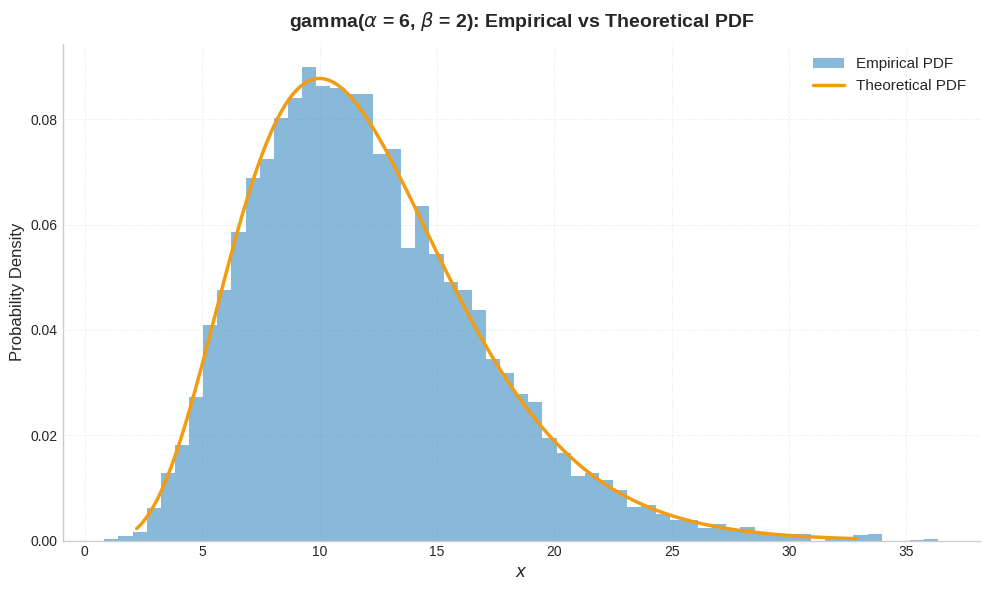

In [5]:
gamma_rv = scistats.gamma(a=alpha, scale=2)
save_path_1 = os.path.join(ROOT, "images/sampling/EmpvsTheo_gamma.png")
plot_empirical_and_theoretical_pdf(gamma_samples,gamma_rv,dist_name=rf"gamma($\alpha$ = {alpha}, $\beta$ = {beta})",save_path=save_path_1)

## 2. Chi–Square Distribution (Even Degrees of Freedom)

A chi–square random variable with $p$ degrees of freedom can be represented as

$$
\chi^2_p \;\sim\; \mathrm{Gamma}\!\left(\frac{p}{2},\,2\right)
$$

Hence, for even degrees of freedom $p = 2v$, the chi–square distribution can be generated directly from the Gamma distribution with integer shape parameter $v$ and scale $\beta = 2$.

If $U_1, U_2, \dots, U_v \overset{\text{iid}}{\sim} \mathrm{Unif}(0,1)$, then

$$
Y = -2 \sum_{j=1}^{v} \ln(U_j) \;\sim\; \chi^2_{2v}
$$

---

### Proof

From the previous section, we know that if

$$
Y = -\beta \sum_{j=1}^{a} \ln(U_j)
$$

then $Y \sim \mathrm{Gamma}(a, \beta)$ for integer $a$.  
Setting $\beta = 2$ and $a = v$, we have

$$
Y \sim \mathrm{Gamma}(v,2) \;=\; \chi^2_{2v}
$$

Hence, the chi–square distribution with even degrees of freedom can be generated by summing $v$ independent exponential random variables with scale $2$.

---

### Algorithm (Summary)

1. Generate $v$ independent $U_i \sim \mathrm{Unif}(0,1)$  
2. Transform each as $Y_i = -2 \ln(U_i)$ to obtain exponential samples with scale $2$  
3. Sum them: $X = \sum_{i=1}^{v} Y_i \sim \chi^2_{2v}$  

## 3. Beta Distribution from Uniform or Gamma Variables

A **Beta** random variable with parameters $(\alpha, \beta)$ can be generated using the relationship

$$
Y = \frac{X_1}{X_1 + X_2}, \qquad
X_1 \sim \mathrm{Gamma}(\alpha, 1), \quad X_2 \sim \mathrm{Gamma}(\beta, 1)
$$

where $X_1$ and $X_2$ are independent Gamma random variables.  
It follows that

$$
Y \sim \mathrm{Beta}(\alpha, \beta)
$$

---

### Proof

Let $X_1$ and $X_2$ be independent Gamma random variables with parameters $(\alpha,1)$ and $(\beta,1)$ respectively.  
Their joint density is

$$
f_{X_1,X_2}(x_1,x_2) = \frac{1}{\Gamma(\alpha)\Gamma(\beta)} \, x_1^{\alpha-1}x_2^{\beta-1} e^{-(x_1+x_2)}, 
\qquad x_1,x_2>0
$$

Now define the transformation:

$$
T = X_1 + X_2, \qquad Y = \frac{X_1}{X_1 + X_2}
$$

Then the inverse transformation is:

$$
X_1 = YT, \qquad X_2 = (1-Y)T
$$

and the Jacobian determinant is $|J| = T$.  

Substituting, we get the joint density of $(Y,T)$:

$$
\begin{aligned}
f_{Y,T}(y,t)
&= f_{X_1,X_2}(yt,(1-y)t) \, |J| \\
&= \frac{1}{\Gamma(\alpha)\Gamma(\beta)} \, (yt)^{\alpha-1} \big((1-y)t\big)^{\beta-1} e^{-t} \, t \\
&= \frac{t^{\alpha+\beta-1} e^{-t}}{\Gamma(\alpha)\Gamma(\beta)} \, y^{\alpha-1}(1-y)^{\beta-1}
\end{aligned}
$$

Integrating out $t$ gives the marginal density of $Y$:

$$
\begin{aligned}
f_Y(y)
&= \int_0^\infty f_{Y,T}(y,t) \, dt \\
&= \frac{y^{\alpha-1}(1-y)^{\beta-1}}{\Gamma(\alpha)\Gamma(\beta)} 
    \int_0^\infty t^{\alpha+\beta-1} e^{-t} \, dt \\
&= \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} \, y^{\alpha-1}(1-y)^{\beta-1}, 
\qquad 0<y<1
\end{aligned}
$$

Thus,

$$
Y \sim \mathrm{Beta}(\alpha, \beta)
$$

---

### Constructive Generation (from Uniforms)

From the previous section, Gamma random variables can be constructed from $\mathrm{Unif}(0,1)$ samples:

$$
X_1 = -\sum_{i=1}^{\alpha} \ln(U_i), \qquad
X_2 = -\sum_{j=1}^{\beta} \ln(V_j),
$$

where $U_i, V_j \overset{\text{iid}}{\sim} \mathrm{Unif}(0,1)$.  
Then,

$$
Y = \frac{X_1}{X_1 + X_2} \;\sim\; \mathrm{Beta}(\alpha, \beta),
$$

for integer $\alpha, \beta \in \mathbb{N}$.

---

### Algorithm (Summary)

1. Generate $X_1 = \mathrm{Gamma}(\alpha, 1)$ and $X_2 = \mathrm{Gamma}(\beta, 1)$ independently  
   (using Uniform-to-Gamma transformations).  
2. Compute $Y = \dfrac{X_1}{X_1 + X_2}$.  
3. Then $Y \sim \mathrm{Beta}(\alpha, \beta)$.


In [6]:
num_samples = 10000
p = 4
chisquare_samples = sample_chisquare_even(p,num_samples)

The empirical distribution obtained from simulated $\mathrm{Beta}(\alpha, \beta)$ samples 
can be compared with the theoretical Beta density to verify the transformation.

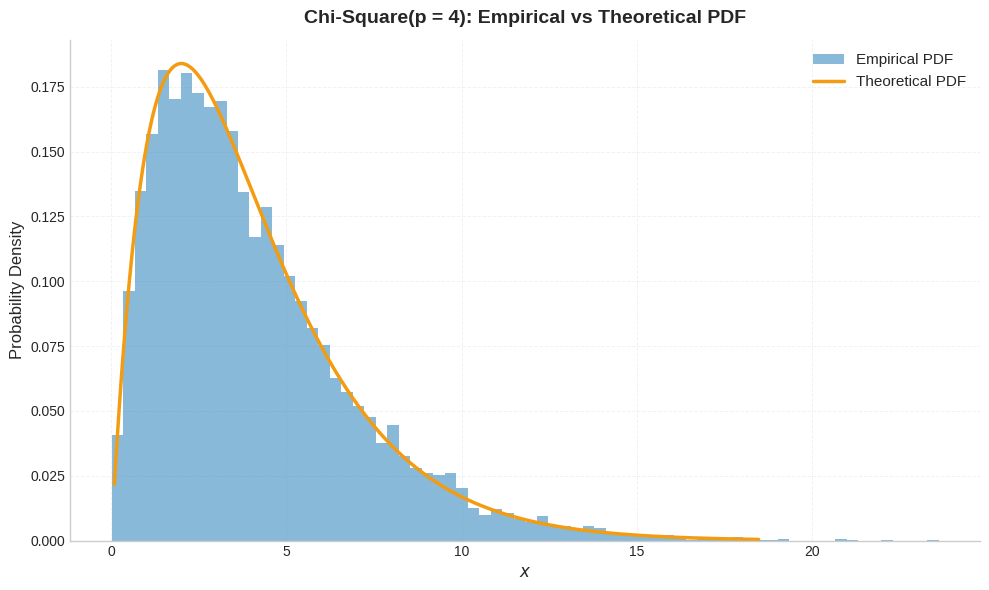

In [5]:
chisquare_rv = scistats.chi2(df=p)
plot_empirical_and_theoretical_pdf(chisquare_samples,chisquare_rv,dist_name=rf"Chi-Square(p = {p})",save_path="images/Ch02_general_tranformations/EmpvsTheo_chisquare.png")

In [6]:
num_samples = 10000
alpha = 10; beta = 3
beta_samples = sample_beta_integer_param(alpha, beta, num_samples)

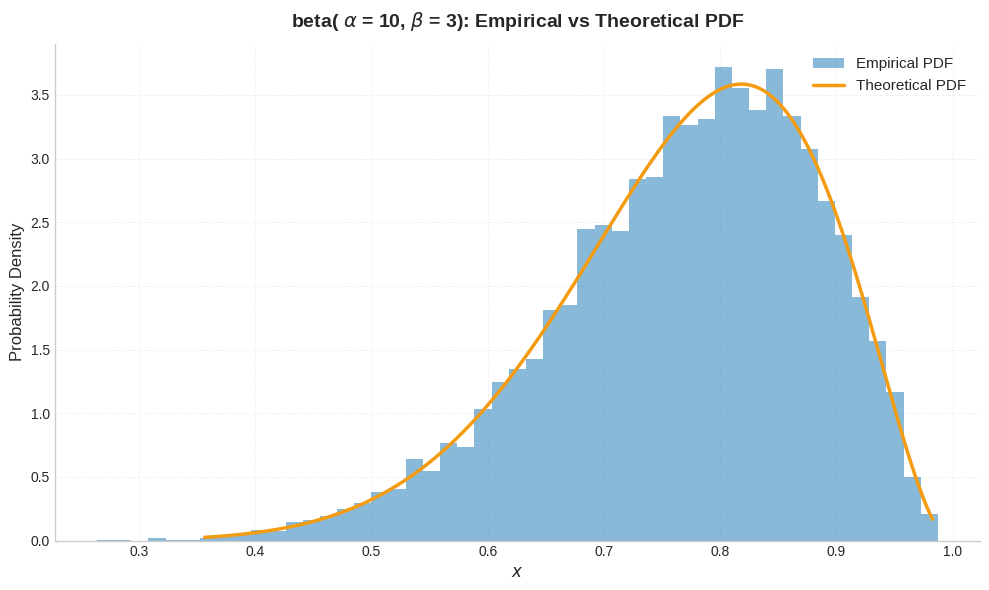

In [7]:
beta_rv = scistats.beta(alpha, beta)
plot_empirical_and_theoretical_pdf(beta_samples,beta_rv,dist_name=rf"beta( $\alpha$ = {alpha}, $\beta$ = {beta})",save_path="images/Ch02_general_tranformations/EmpvsTheo_beta.png")

## 4. Logistic Distribution from Uniform(0,1)

If $U \sim \mathrm{Unif}(0,1)$, then

$$
X = \log\!\left(\frac{U}{1-U}\right) \sim \mathrm{logistic}(0,1)
$$

This can be extended to generate the general $\mathrm{logistic}(\mu,\beta)$ distribution.

---

### Claim 1: $X = \log\!\left(\dfrac{U}{1-U}\right)$ is $\mathrm{logistic}(0,1)$

**Proof**

Let $U \sim \mathrm{Unif}(0,1)$ and define

$$
X = g(U) = \log\!\left(\frac{U}{1-U}\right)
\qquad \implies \qquad
U = g^{-1}(X) = \frac{e^{X}}{1+e^{X}}
$$

Differentiate the inverse:

$$
\frac{d g^{-1}(x)}{dx} = \frac{e^{x}}{(1+e^{x})^{2}}
$$

Since $f_U(u) = 1$ for $0 < u < 1$, applying the change-of-variable rule gives:

$$
\begin{aligned}
f_X(x)
    &= f_U(g^{-1}(x)) \left| \frac{d g^{-1}(x)}{dx} \right| \\
    &= 1 \times \frac{e^{x}}{(1+e^{x})^{2}}
    = \frac{e^{x}}{(1+e^{x})^{2}}, \qquad x \in \mathbb{R}
\end{aligned}
$$

---

**Simplification**

To express it symmetrically, multiply numerator and denominator by $e^{-2x}$:

$$
\frac{e^{x}}{(1+e^{x})^{2}}
= \frac{e^{x}e^{-2x}}{(1+e^{x})^{2}e^{-2x}}
= \frac{e^{-x}}{(1+e^{-x})^{2}}
$$

Both forms are equivalent; the latter highlights the symmetry about $x=0$.

Hence,

$$
f_X(x) = \frac{e^{-x}}{(1+e^{-x})^{2}},
\qquad
F_X(x) = \frac{1}{1+e^{-x}}
$$

which correspond to the $\mathrm{logistic}(0,1)$ pdf and cdf.

---

### Claim 2: Generate a $\mathrm{logistic}(\mu,\beta)$ random variable

**Proof**

If $X \sim \mathrm{logistic}(0,1)$, define

$$
Y = \mu + \beta X, \qquad \beta > 0
$$

Then by the location–scale transformation,

$$
F_Y(y)
    = \mathbb{P}(Y \le y)
    = \mathbb{P}\!\left(X \le \frac{y-\mu}{\beta}\right)
    = \frac{1}{1+\exp\!\left(-\frac{y-\mu}{\beta}\right)}
$$

and differentiating,

$$
f_Y(y)
    = \frac{\exp\!\left(-\frac{y-\mu}{\beta}\right)}
           {\beta\left(1+\exp\!\left(-\frac{y-\mu}{\beta}\right)\right)^{2}},
    \qquad y \in \mathbb{R}
$$

Thus, $Y \sim \mathrm{logistic}(\mu,\beta)$.

---

### Algorithm (Summary)

1. Generate $U \sim \mathrm{Unif}(0,1)$  
2. Compute $X = \log\!\left(\dfrac{U}{1-U}\right)$  
3. Transform as $Y = \mu + \beta X$  
   Then $Y \sim \mathrm{logistic}(\mu,\beta)$


In [8]:
num_samples = 10000
mu = 3; beta = 0.5
logistic_samples = sample_logistic(mu, beta, num_samples)

The empirical histogram obtained from simulated samples is compared with the theoretical logistic pdf to validate the transformation method.

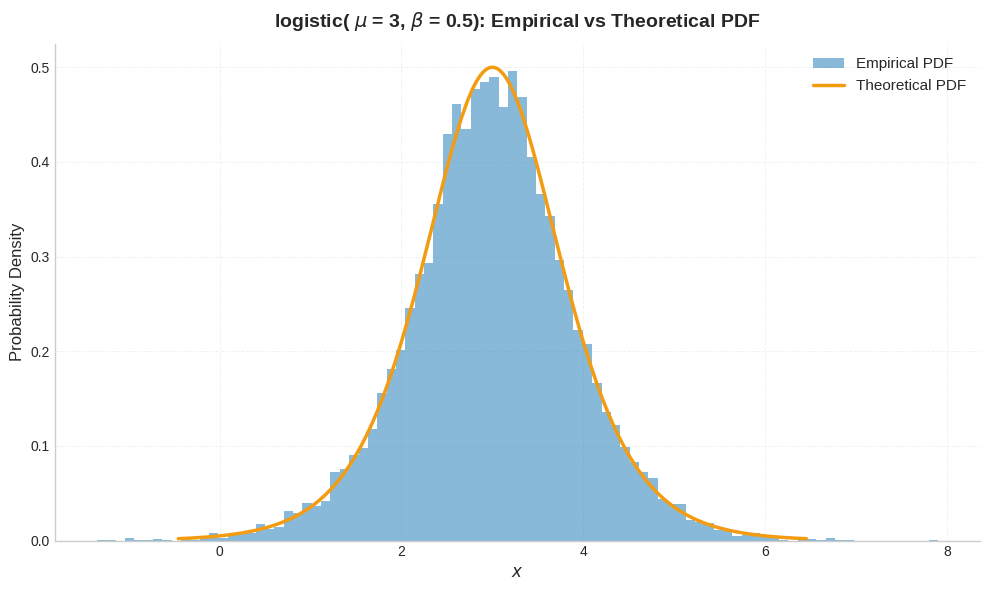

In [9]:
logistic_rv = scistats.logistic(mu, beta)
save_path_2 = os.path.join(ROOT, "images/sampling/EmpvsTheo_logistic.png")
plot_empirical_and_theoretical_pdf(logistic_samples,logistic_rv,dist_name=rf"logistic( $\mu$ = {mu}, $\beta$ = {beta})",save_path=save_path_2)

In [10]:
num_samples = 10000
mu = 5.0; sigma = 10.2
laplace_samples = sample_laplace(mu, sigma, num_samples)

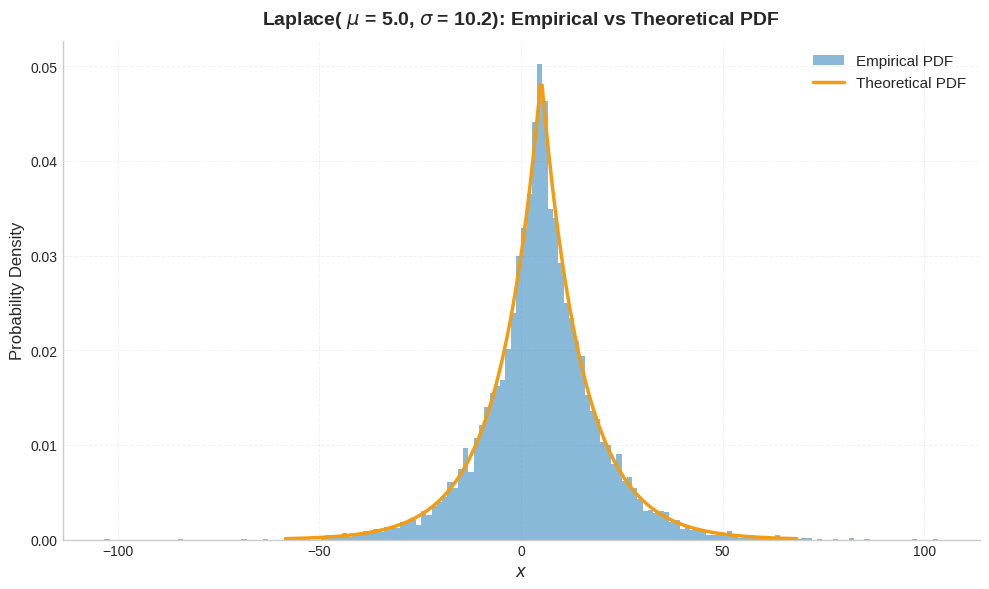

In [11]:
laplace_rv = scistats.laplace(loc=mu, scale=sigma)
save_path_3 = os.path.join(ROOT, "images/sampling/EmpvsTheo_laplace.png")
plot_empirical_and_theoretical_pdf(laplace_samples,laplace_rv,dist_name=rf"Laplace( $\mu$ = {mu}, $\sigma$ = {sigma})",save_path=save_path_3)

## Animation 

In [12]:
num_samples = 10000
alpha = 10; beta = 3
beta_samples = sample_beta_integer_param(alpha, beta, num_samples)
beta_rv = scistats.beta(alpha, beta)

In [13]:
# Generate animation
save_path_4 = os.path.join(ROOT, "animations/beta_fill.gif")
animate_histogram_falling_sand_density(
    samples=beta_samples,
    rv=beta_rv,
    dist_name=rf"Beta($\alpha$={alpha}, $\beta$={beta})",
    out_path=save_path_4,
    kind="gif"
)

'/home/saisampathkedari/MonteCarlo-Statistical-Methods/animations/beta_fill.gif'